# Clasificación de sentimientos: Enfoque de Aprendizaje de Máquina

En este notebook, vas a usar [scikit-learn](https://scikit-learn.org/), una de las librerías mas importantes para construcción de modelos de aprendizaje de máquina, para la construcción de un clasificador de sentimientos. El objetivo es identificar si una crítica de una película es positiva o negativa.  Este notebook esta dividido en tres secciones que representan las etapas típicas en la construcción de soluciones de procesamiento de lenguaje natural.

- *Procesamiento del texto*: Vamos a entender el dataset y procesar el texto.
- *Estrategia de representación*: Construiremos una representación básica de bolsa de palabras utilizando la funcionalidad CountVectorizer de sklearn.
- *Modelamiento y evaluación*: Entrenaremos un clasificador Naive Bayes y evaluaremos su desempeño. Tambien utilizaremos el modelo construido para predecir la polaridad en texto construido por nosotros.

In [1]:
### Lo primero que vamos a realizar es la importación de las librerías necesarias para la construcción de nuestro clasificador

## Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

## Librerias para graficación
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK es una librería particular para PLN. Tiene muchas funcionalidades entre ellas stemming y lista de palabras de parada.
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd


stemmer = nltk.stem.SnowballStemmer('spanish') # Vamos a utlizar el Snowball Stemmer para realizar stemming (nos permite llevar las palabras a una forma estandar).
nltk.download('stopwords') # Lista de palabras de parada en español.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pms_l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Procesamiento del texto

#### 1.1. Dataset

Vamos a utlizar una versión modificada del dataset abierto de criticas de películas Españolas de Kaggle: [Críticas películas filmaffinity en Español](https://www.kaggle.com/datasets/ricardomoya/criticas-peliculas-filmaffinity-en-espaniol). El dataset se encuentra en archivo csv "Tutorial-NLP_Analisis_de_Sentimientos.csv".

Para leer este archivo y operarlo vamos a hacer uso de la librería de python [Pandas](https://pandas.pydata.org/) y su método de lectura [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html).

In [2]:
df = pd.read_csv('Tutorial-NLP_Analisis_de_Sentimientos.csv', sep=',', header=0, index_col= None, engine='python',
                 usecols=['film_name','gender','review_title','review_text','polaridad'])

## Una vez realizado el cargue del dataset en un dataframe de pandas podemos explorarlo!
## Revisemos 5 ejemplos del dataset.
df.sample(5)

,film_name,gender,review_title,review_text,polaridad
1533,Tengo ganas de ti,Romance,La culpa es del 3d,La culpa la tiene el despropósito tecnológico ...,negativo
1515,Lo imposible,Drama,"Técnicamente estupenda, historia mejorable","Por fin he podido ver ""Lo imposible"" de JJ Bay...",positivo
1084,Perfectos desconocidos,Comedia,Interesante como entretenimiento y como fuente...,Perfectos desconocidos es una película dramáti...,positivo
2066,Campeones,Comedia,Yo soy Marco Montes,Después de formar como programadores a ingenie...,positivo
1289,Campeones,Comedia,Buenissima,Es una peli tan buena que con el tiempo seguro...,positivo


Cada ejemplo del dataset (fila) representa una crítica realizada por un usuario a una pelicula.

- La columna '*film_name*' indica el nombre de la película objeto de la crítica.
- La columna '*gender*' indica el género de la película.
- La columna '*review title*' es el título de la crítica.
- La columna '*polaridad*' es la categoría/label asignado a la crítica.


Revisemos la critica en la fila número 2895 en nuestro dataset. Para acceder vamos a utilizar [iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) que nos permite seleccionar por indice.

In [3]:
df.loc[2895].review_text

'Me aburrí.  No le vi la gracia a Ocho Apellidos Vascos, mucho menos se la voy a ver a este desgraciado efecto secundario.  El caso es que empecé a verla con ganas, a ver si por lo menos me reía de algún chiste, pero, o no los distinguí, o no existen en el texto o ando espesito yo.  El guión es un absurdo sin gracia, porque hay absurdos graciosos, pero no este, y si no hay guión no hay peli por mucho que tengamos a Karra y a la Sardá.  Me los imagino a los dos compartiendo unas kokotxas con xamfaina y haciéndose confidencias acerca de lo que tiene que hacer uno para que le quede una pensión decente.En realidad esta es la crítica de las tres cuartas partes de la película, el final me cogió haciéndome el colacao para irme a la cama.'

Claramente la crítica es negativa, pero revisemos su categoría/label.

In [4]:
df.loc[2895].polaridad

'negativo'

Revisemos ahora cuantos ejemplos de críticas negativas y positivas tenemos en nuestro dataset. Esta información es relevante para:
- Seleccionar la relación entre particiones de entrenamiento y testing de nuestro dataset.
- Conocer si las clases estas balanceadas (cada clase tiene el mismo número de ejemplos).
- Seleccionar le modelo de aprendizaje de máquina mas apropiado.

Vamos a utilizar la función [catplot](https://seaborn.pydata.org/generated/seaborn.catplot.html) de la librería seaborn para la elaboración de un histograma.

C:\Users\pms_l\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-3.6805555555555554, 0.5, 'Conteo')

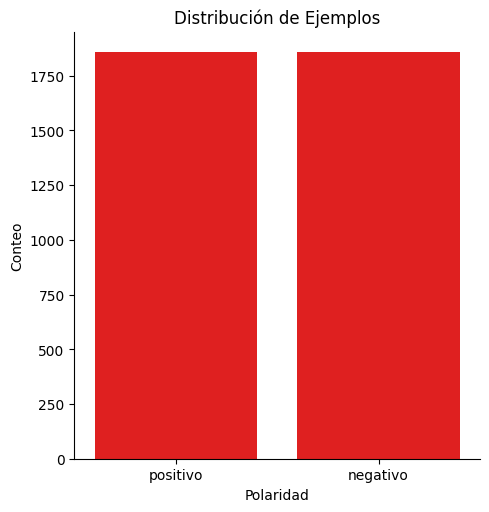

In [5]:
sns.catplot(x='polaridad', kind='count', color='r', data=df)
plt.title('Distribución de Ejemplos')
plt.xlabel('Polaridad')
plt.ylabel('Conteo')

Del histograma se puede evidenciar:
- Tenemos 1857 ejemplos de cada clase (positivo, negativo). Las clases estan perfectamente balanceadas.
- En total tenemos 3714 ejemplos en el dataset.

#### 1.2. Unificación de texto

En nuestro dataset tenemos dos fuentes de información textual de la crítica la columna review_text y la columna review_title. Vamos a concatenar ambos textos en una sola nueva columna que denomineros "*texto*". Usaremos su contenido para construir una representación de bolsa de palabras y posteriormente un modelo de Naive Bayes.

In [6]:
df['texto'] = df['review_title'] + ' ' + df['review_text']
df.head(5)

,film_name,gender,review_title,review_text,polaridad,texto
0,Volver,Drama,"VOLVER AL PASADO, LA ETERNA RECURRENCIA",La última película de Almodóvar vuelve a ser u...,positivo,"VOLVER AL PASADO, LA ETERNA RECURRENCIA La últ..."
1,Mar adentro,Drama,Genialmente Horrible,"Sinceramente, pienso que el fondo de la crític...",negativo,"Genialmente Horrible Sinceramente, pienso que ..."
2,Celda 211,Thriller,sobrevaloradísima,"Lo siento, pero fui a verla con muchas expecta...",negativo,"sobrevaloradísima Lo siento, pero fui a verla ..."
3,Las aventuras de Tadeo Jones,Animación,Insultante.,"La pelicula es muy mala. Incluso más que mala,...",negativo,Insultante. La pelicula es muy mala. Incluso m...
4,Mientras dure la guerra,Drama,"Valiente Unamuno, o justicia para Unamuno, o r...","Una buena película, quizá gran película y muy ...",positivo,"Valiente Unamuno, o justicia para Unamuno, o r..."


#### 1.3. Función de procesamiento

Vamos a definir ahora una función "*processing_text*" encargada de modificar el texto de forma apropiada para ser usado en la representación. Es importante aclarar que el procesamiento cambia de acuerdo al dataset y el problema que se esta resolviendo, no existe una única formula mágica.

In [7]:
'''
* processing_text
* @param texto str
* @return processed_feature str
'''
def processing_text(texto):
    # Paso 1: Remover con un expresión regular carateres especiales (no palabras).
    processed_feature = re.sub(r'\W', ' ', str(texto))
    # Paso 2: Remover ocurrencias de caracteres individuales
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    # Paso 3: Remover números (Ocurrencias muy esporádicas en nuestro dataset)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    # Paso 4: Simplificar espacios concecutivos a un único espacio entre palabras
    processed_feature = re.sub(' +', ' ', processed_feature)
    # Paso 5: Pasar todo el texto a minúsculas
    processed_feature = processed_feature.lower()
    # Paso 6: Aplicar stemming. Es una forma de enviar las palabras a una raiz común simplificando de esta manera el vocabulario.
    #         por ejemplo las palabras (absurdo, absurdos) que estan en el review 2895 seran llevados a la raiz común "absurd"
    #         y de esta forma se evita tener dos palabras diferentes con el mismo significado en nuestro vocabulario.
    processed_feature = " ".join([stemmer.stem(i) for i in processed_feature.split()])

	#
 
    return processed_feature



Ahora que ya tenemos nuestra función de procesamiento la vamos a aplicar a nuestro dataset.

In [8]:
# Primero vamos extraer del dataframe la columna texto y la polaridad y las almacenaremos en las variables
# texto_para_procesar y labels respectivamente
texto_para_procesar = df['texto'].values
labels = df['polaridad'].values

# El texto ya procesado de cada ejemplo en nuestro dataset lo almacenaremos en la variable "texto_procesado"
texto_procesado = []
for sentence in range(0, len(texto_para_procesar)):
    procesado = processing_text(texto_para_procesar[sentence])
    texto_procesado.append(procesado)

In [9]:
# Comparemos ahora la crítica 2895 procesada vs no procesada.
print("Sin procesar:")
print(texto_para_procesar[2895])
print("---------------------------------")
print("Procesado:")
print(texto_procesado[2895])

Sin procesar:
No pude acabar de verla Me aburrí.  No le vi la gracia a Ocho Apellidos Vascos, mucho menos se la voy a ver a este desgraciado efecto secundario.  El caso es que empecé a verla con ganas, a ver si por lo menos me reía de algún chiste, pero, o no los distinguí, o no existen en el texto o ando espesito yo.  El guión es un absurdo sin gracia, porque hay absurdos graciosos, pero no este, y si no hay guión no hay peli por mucho que tengamos a Karra y a la Sardá.  Me los imagino a los dos compartiendo unas kokotxas con xamfaina y haciéndose confidencias acerca de lo que tiene que hacer uno para que le quede una pensión decente.En realidad esta es la crítica de las tres cuartas partes de la película, el final me cogió haciéndome el colacao para irme a la cama.
---------------------------------
Procesado:
no pud acab de verl me aburr no le vi la graci ocho apell vasc much men se la voy ver este desgraci efect secundari el cas es que empec verl con gan ver si por lo men me rei de 

.
.
.


Debido al proceso de stemming ahora el texto es mucho mas dificil de leer, sin embargo, el stemming nos permitirá tener un vocabulario reducido.
Ahora solo nos hace falta una etapa del procesamiento que es la eliminación de *palabras de parada*. Las palabras de parada son las palabras más comunes en cualquier idioma:  artículos, preposiciones, pronombres, conjunciones, etc. y no agregan mucha información sobre la semántica del texto. Veamos una lista de estas palabras:

In [10]:
print(stopwords.words('spanish'))

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

La eliminación de palabras de parada no siempre es apropiada en las tareas de procesamiento de lenguaje natural. Por ejemplo, si queremos construir un modelo que genere texto coherente es necesario preservar la estructura sintáctica del lenguaje y esto incluye por supuesto las palabras de parada.

## 2. Representación del texto

En esta etapa debemos tomar el texto procesado y representarlo de alguna forma que nos permita operarlo apropiadamente. Vamos a usar la representación más básica que es la *bolsa de palabras*.  Una bolsa de palabras es una representación de texto que describe la ocurrencia de palabras dentro de un documento e implica:

- Un vocabulario de palabras.
- Una ponderación de la presencia de palabras del vocabulario. La forma mas simple es realizar el conteo de las ocurrecias de las palabras del vocabulario en el texto.

Se llama *bolsa de palabras*, porque se descarta cualquier información sobre el orden o la estructura de las palabras en el documento. El modelo solo se preocupa por si las palabras conocidas ocurren en el documento o no. Para construir una bolsa de palabras en sklearn podemos hacer uso de [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) que construye el vocabulario de palabras de nuestro conjunto de datos y transforma el texto en un vector de conteo de palabras.

In [11]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=2500, stop_words=stopwords.words('spanish'))
# max_features representa el tamaño del vocabulario. Vamos a permitir 2500 palabras.
# stop_words le indicamos las palabras de parada para que las ignore en el vocabulario.

# Ahora le solicitamos utilizando nuestro conjunto de datos que construya el vocabulario y tambien transforme nuestro texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray()


#### 2.1. Vocabulario

Revisemos el vocabulario. *CountVectorizer* tomo todas las críticas del dataset, extrajo todas las palabras diferentes y calculo el número de apariciones. De todas las palabras matuvo las 2500 mas frecuentes sin tener en cuenta la lista de palabras de parada.

In [12]:
# Para ver las primeras 10 palabras del vocabulario podemos hacer uso del método get_feature_names
vectorizer.get_feature_names_out()[0:10]

array(['abaj', 'abandon', 'abarc', 'aberr', 'abiert', 'abord', 'abre',
       'absolut', 'absurd', 'abuel'], dtype=object)

In [30]:
texto_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

#### 2.2. Representación vectorial del texto

Una vez construido el vocabulario, *CountVectorizer* construye una representación vectorial de cada crítica. El valor de cada dimensión de dicho vector corresponde al número  de ocurrencias de una palabra del vocabulario. Este vector tendra po lo tanto tantas dimensiones como palabras en el vocabulario, en nuestro caso 2500.

Volvamos al texto procesado de la crítica 2895:

*"no pud acab de verl me aburr no le vi la graci ocho apell vasc much men se la voy ver este desgraci efect secundari el cas es que empec verl con gan ver si por lo men me rei de algun chist per no los distingu no exist en el text ando espesit yo el guion es un absurd sin graci porqu hay absurd gracios per no este si no hay guion no hay peli por much que teng karr a la sard me los imagin los dos compart unas kokotx con xamfain hac confident acerc de lo que tien que hac uno par que le qued una pension decent en realid esta es la critic de las tres cuart part de la pelicul el final me cog hac el colaca par irme la cam
"*

Como se pueden dar cuenta la palabra *absurd* aparece dos veces en el texto. Esta palabra es la número 9 en nuestro vocabulario, por lo tanto la representación vectorial de la crítica 2895 deberá contener un 2 (frecuencia) en la dimension 9.

In [43]:
len(vectorizer.get_feature_names_out())

2500

In [41]:
vectorizer.get_feature_names_out()[:10]

array(['abaj', 'abandon', 'abarc', 'aberr', 'abiert', 'abord', 'abre',
       'absolut', 'absurd', 'abuel'], dtype=object)

In [35]:
texto_procesado[2895]

'no pud acab de verl me aburr no le vi la graci ocho apell vasc much men se la voy ver este desgraci efect secundari el cas es que empec verl con gan ver si por lo men me rei de algun chist per no los distingu no exist en el text ando espesit yo el guion es un absurd sin graci porqu hay absurd gracios per no este si no hay guion no hay peli por much que teng karr a la sard me los imagin los dos compart unas kokotx con xamfain hac confident acerc de lo que tien que hac uno par que le qued una pension decent en realid esta es la critic de las tres cuart part de la pelicul el final me cog hac el colaca par irme la cam'

In [36]:
print(len(texto_features[2895])) # Longitud del vector que representa a la crítica 2895.
print(texto_features[2895][0:100]) # 100 primeras posiciones del vector de la crítica. Puede ubicar la dimensión correspondiente a la palabra "absurb"?

2500
[0 0 0 0 0 0 0 0 2 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


## 3. Modelamiento y evaluación

Ahora que tenemos nuestra representación, es necesario construir y evaluar nuestro modelo de Naive Bayes. Necesitamos un subconjunto de los datos para construir nuestro modelo probabilisitico (train) y otro subconjunto para evaluarlo (test).

In [14]:
# Aca dividimos nuestro dataset en entrenamiento y texto. 20% para evaluar (test) y 80% para entrenamiento (train).
# En las variables X_ quedaran almacenados las presentaciones vectoriales de las críticas.
# En las variables y_ las etiquetas o categorias (polaridad de la crítica).
X_train, X_test, y_train, y_test = train_test_split(texto_features, labels, test_size=0.2, random_state=0)

Ahora vamos a entrenar el modelo. En sklearn [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=multinomialnb#sklearn.naive_bayes.MultinomialNB) nos permite entrenar un modelo de Naive Bayes.

In [15]:
# Ahora entrenemos un modelo simple. Ya conocenos Naive Bayes!!
nb = MultinomialNB()
# El método fit en sklearn permite ejecutar el proceso de entrenamiento.
nb.fit(X_train, y_train)

MultinomialNB()

#### 3.1. Evaluación

Listo, ya tenemos nuesto modelo de Naive Bayes entrenado, es necesario evaluarlo con el cunjunto de test. Vamos a utilizar una metrica conocida como accuracy que representa la relación de críticas para las cuales el modelo predijo correctamente la crítica. Un valor de 1 en el accuracy indica que a todas las criticas se les predijo correctamente la polaridad, mientras que un accuracy de 0 indica que el modelo fallo todas sus predicciones. Existen otras métricas de evaluación pero por ahora lo vamos a mantener simple.

In [16]:
# Ahora vamos a evaluar que tan bueno es nuestro modelo NB, utlilizando el conjunto de datos de test.
# Para predecir utlizamos el método predict.

predictions = nb.predict(X_test)

In [17]:
# Ahora calculamos el score de accuracy enviando las predicciónes y los valores reales de polaridad.
print(accuracy_score(y_test, predictions))

0.8586810228802153


Un accuracy mayor al 80% no esta nada mal para un modelo simple como Naive Bayes. Vamos ahora a jugar un poco con el modelo y enviarle texto que nosotros construyamos.

In [18]:

# Utilizemos la siguiente frase de test (sientanse en la libertad de cambiarla).
test = "Fue la mejor pelicula Pelicula que he visto en mi vida"

# Recuerden el modelo recibe la representación vectorial del texto, no el texto en bruto. Debemos procesar y representar el texto.

test_procesado = processing_text(test) # Aplicamos nuestra función de procesamiento
print("PASO 1 procesamiento:" ,test_procesado)

test_bow =vectorizer.transform([test_procesado]) # Ahora lo representamos como una bolsa de palabras. El vector resultante tiene 2500 posiciones.
print("PASO 2 representación:" ,test_bow) # En esa impresion no aparecen las 2500 posiciones del vector, solo la lista de posiciones que son diferentes de cero.

# Ahora que ya lo tenemos en la representación adecuada lo podemos enviar al modelo para que este prediga su polaridad.
clase_test = nb.predict(test_bow)
print("PASO 3 predecir con el modelo:" ,clase_test)

PASO 1 procesamiento: fue la mejor pelicul pelicul que he vist en mi vid
PASO 2 representación:   (0, 1484)	1
  (0, 1733)	2
  (0, 2450)	1
  (0, 2469)	1
PASO 3 predecir con el modelo: ['positivo']


Modifique el texto en la variable test para que el modelo ahora prediga una polaridad negativa. ¿Se le ocurre alguna forma de confundir al modelo para que la predicción sea incorrecta?, pruebe por ejemplo doble negaciones en el texto.

In [19]:
## OPCIONAL
## Vamos a profundizar en estos conceptos mas adelante.
cm = confusion_matrix(y_test, predictions,labels=nb.classes_)

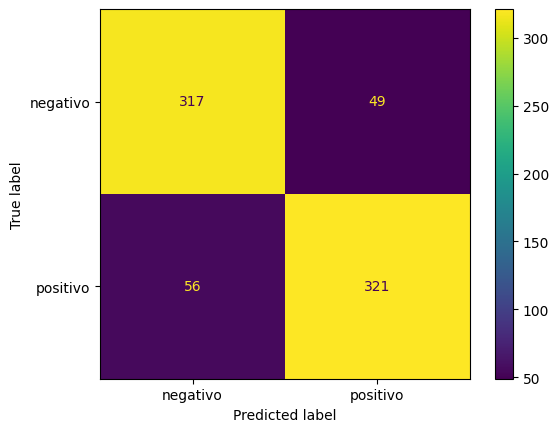

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot()

In [21]:
## OPCIONAL
print(classification_report(y_test, predictions, digits=4))

              precision    recall  f1-score   support

    negativo     0.8499    0.8661    0.8579       366
    positivo     0.8676    0.8515    0.8594       377

    accuracy                         0.8587       743
   macro avg     0.8587    0.8588    0.8587       743
weighted avg     0.8588    0.8587    0.8587       743

